In [2]:
%pylab inline
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [3]:
root_dir = os.path.abspath('../..')
data_dir = os.path.join(root_dir, 'Paromita.Banerjee/Downloads/fashionmnist')
#sub_dir = os.path.join(root_dir, 'sub')
os.path.exists(root_dir)
os.path.exists(data_dir)
print(data_dir)

/Users/Paromita.Banerjee/Downloads/fashionmnist


In [4]:
train = pd.read_csv(os.path.join(data_dir, 'fashion-mnist_train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'fashion-mnist_test.csv'))
print(train.head(5))

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9    ...     pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0        30        43   
3       0    ...            3         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0         

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(train.drop("label",axis=1),train.label, test_size = 0.20, random_state = 200)

x_train = np.array((x_train*1.0)/255.0,dtype=np.float32)
x_valid = np.array((x_valid*1.0)/255.0,dtype=np.float32)
print(x_train.shape, y_train.shape)

((48000, 784), (48000,))


In [6]:
y_train = OneHotEncoder(sparse = False).fit_transform(y_train.reshape(-1,1)).astype(np.uint8)
y_valid = OneHotEncoder(sparse = False).fit_transform(y_valid.reshape(-1,1)).astype(np.uint8)

/Users/paromita.banerjee/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Users/paromita.banerjee/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [7]:
test_label = test.label.values
y_test = OneHotEncoder(sparse = False).fit_transform(test_label.reshape(-1,1)).astype(np.uint8)
x_test = np.array((test.drop("label",axis=1)*1.0)/255.0,dtype=np.float32)

In [8]:
epochs_completed = 0
index_in_epoch = 0
num_examples = x_train.shape[0]

# serve data by batches
def batch_creator(batch_size):
    
    global x_train
    global y_train
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
       
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        x_train = x_train[perm]
        y_train = y_train[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return x_train[start:end], y_train[start:end]


In [10]:
X = tf.placeholder(tf.float32,[None,784])
y_true = tf.placeholder(tf.float32,[None,10])

Feature1 = 12 
Feature2 = 24
Feature3 = 48
Final = 200

W1 = tf.Variable(tf.truncated_normal([5,5,1,Feature1], stddev=0.1))
b1 = tf.Variable(tf.ones([Feature1])/10)
W2 = tf.Variable(tf.truncated_normal([5,5,Feature1,Feature2], stddev=0.1))
b2 = tf.Variable(tf.ones([Feature2])/10)
W3 = tf.Variable(tf.truncated_normal([4,4,Feature2,Feature3], stddev=0.1))
b3 = tf.Variable(tf.ones([Feature3])/10)

W4 = tf.Variable(tf.truncated_normal([7 * 7 * Feature3, Final], stddev=0.1))
b4 = tf.Variable(tf.ones([Final])/10)
W5 = tf.Variable(tf.truncated_normal([Final, 10], stddev=0.1))
b5 = tf.Variable(tf.ones([10])/10)

# Hidden layers
X1 = tf.reshape(X,shape = [-1,28,28,1])
stride = 1  
Y1 = tf.nn.relu(tf.nn.conv2d(X1, W1, strides=[1, stride, stride, 1], padding='SAME') + b1)
stride = 2 
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + b2)
stride = 2  
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + b3)

YY = tf.reshape(Y3, shape=[-1, 7 * 7 * Feature3])

Model = tf.nn.relu(tf.matmul(YY, W4) + b4)

keep_prob = tf.placeholder('float')
F_drop_out = tf.nn.dropout(Model, keep_prob)

Ylogits = tf.matmul(F_drop_out, W5) + b5
y_pred = tf.nn.softmax(Ylogits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= Ylogits, labels = y_true)
cost = tf.reduce_mean(cross_entropy)

global_step = tf.Variable(0, trainable=False)
learning_rate = 0.001

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))



(TensorShape([Dimension(None), Dimension(784)]), TensorShape([Dimension(None), Dimension(10)]))


In [118]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

print("Training step")
for i in range(1000):
    batch_x_tr, batch_y_tr = batch_creator(100)
    _,a = sess.run([train_step,accuracy],feed_dict = {X: batch_x_tr, y_true: batch_y_tr,keep_prob: 0.65})
    if i % 100 == 0:
        print("Step:",i, "Accuracy:",a)

a_valid = sess.run(accuracy, feed_dict = {X: x_valid, y_true: y_valid,keep_prob: 1.0})
print("Validation accuracy", a_valid)

Training step
('Step:', 0, 'Accuracy:', 0.11)
('Step:', 100, 'Accuracy:', 0.76999998)
('Step:', 200, 'Accuracy:', 0.81)
('Step:', 300, 'Accuracy:', 0.85000002)
('Step:', 400, 'Accuracy:', 0.82999998)
('Step:', 500, 'Accuracy:', 0.79000002)
('Step:', 600, 'Accuracy:', 0.81)
('Step:', 700, 'Accuracy:', 0.86000001)
('Step:', 800, 'Accuracy:', 0.88)
('Step:', 900, 'Accuracy:', 0.82999998)
('Validation accuracy', 0.88775003)


In [119]:
a_ts = sess.run(accuracy, feed_dict = {X: x_test, y_true: y_test,keep_prob: 1.0})
print("Test accuracy", a_ts)

('Test accuracy', 0.89020002)


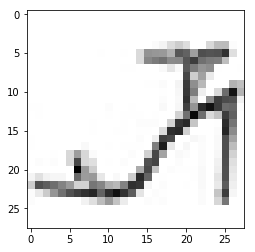

In [123]:
plt.imshow(np.reshape(x_test[15],(28,28)),cmap='gray_r')
plt.show()